# Solve TSP problem using Genetic Algorithm

Tanaz Ghahremani, Hasti Khajeh, Negin Mohammadi, Sina Rostami

## Import libraries

In [ ]:
import numpy as np, random, operator, pandas as pd, matplotlib.pyplot as plt, psutil, json, datetime, tracemalloc

## Model Gen and Chromosome

In [ ]:
class City: # Gen in GA
    def __init__(self, x, y):
        self.x = x
        self.y = y

    def distance(self, city):
        xDis = abs(self.x - city.x)
        yDis = abs(self.y - city.y)
        distance = np.sqrt((xDis ** 2) + (yDis ** 2))
        return distance

    def __repr__(self):
        return "(" + str(self.x) + "," + str(self.y) + ")"

In [ ]:
class Route: # Chromosome in GA
    def __init__(self, cities : list):
        self.cities = cities
        self.fitness = 0
        self.distance = 0

    def calculate_distance(self):
        if self.distance == 0:
            pathDistance = 0
            for i in range(0, len(self.cities)):
                fromCity = self.cities[i]
                toCity = None
                if i + 1 < len(self.cities):
                    toCity = self.cities[i + 1]
                else:
                    toCity = self.cities[0]
                pathDistance += fromCity.distance(toCity)
            self.distance = pathDistance
        return self.distance

    def calculate_fitness(self):
        if self.fitness == 0:
            self.fitness = 1 / float(self.calculate_distance())
        return self.fitness

## GA functions

In [ ]:
def create_route(cityList):
    route = random.sample(cityList, len(cityList))
    return route

In [ ]:
def initial_population(population_size, cityList):
    population = []

    for i in range(0, population_size):
        population.append(create_route(cityList))
    return population

In [ ]:
def rank_routes(population):
    fitnessResults = {}
    for i in range(0,len(population)):
        fitnessResults[i] = Route(population[i]).calculate_fitness()
    return sorted(fitnessResults.items(), key = operator.itemgetter(1), reverse = True)

In [ ]:
def selection(ranked_population, elite_size, population):
    selectionResults = []
    df = pd.DataFrame(np.array(ranked_population), columns=["Index","Fitness"])
    df['cum_sum'] = df.Fitness.cumsum()
    df['cum_perc'] = 100*df.cum_sum/df.Fitness.sum()

    for i in range(0, elite_size):
        selectionResults.append(ranked_population[i][0])
    for _ in range(0, len(ranked_population) - elite_size):
        pick = 100*random.random()
        for i in range(0, len(ranked_population)):
            if pick <= df.iat[i,3]:
                selectionResults.append(ranked_population[i][0])
                break

    mating_pool = []
    for i in range(0, len(selectionResults)):
        index = selectionResults[i]
        mating_pool.append(population[index])
    return mating_pool

In [ ]:
def OX1_crossover(parent1, parent2):
    n = len(parent1)
    index_low = random.randint(0, n-2)
    index_high = random.randint(index_low+1, n-1)
    offspring = [-1 for _ in range(n)]
    offspring[index_low: index_high+1] = parent1[index_low: index_high+1]
    j = (index_high + 1)%n
    if index_low == 0:
        k = index_high
    else:
        k = -1
    for i in range(n):
        if parent2[(i+j)%n] not in parent1[index_low: index_high+1]:
            if k == index_low - 1:
                k = index_high + 1
            else:
                k += 1
            offspring[k] = parent2[(i+j)%n]
    return offspring

In [ ]:
def POS_crossover(parent1: list, parent2: list):
    number_of_positions_to_impose = int(random.random() * len(parent1))
    indices = [i for i in range(len(parent1))]
    randome_indices = sorted(random.sample(indices, number_of_positions_to_impose))
    offspring = []
    current_index_of_parent_1 = 0
    i = 0
    selected_cities = [parent2[y] for y in randome_indices]
    while len(offspring) < len(parent1):
        if i in randome_indices:
            offspring.append(parent2[i])
            i += 1
        else:
            if parent1[current_index_of_parent_1] not in selected_cities:
                offspring.append(parent1[current_index_of_parent_1])
                i += 1
            current_index_of_parent_1 += 1
    return offspring

In [ ]:
def ER_crossover(parent1: list, parent2: list):
    def get_neighbors(parent, position):
        prev_city = position - 1 if position - 1 >= 0 else len(parent1) - 1
        next_city = position + 1 if position + 1 < len(parent1) else 0
        return [parent[prev_city], parent[next_city]]

    neighbor_list = {}
    for i, city in enumerate(parent1):
        index_in_parent2 = parent2.index(city)
        neighbor_list[city] = set(get_neighbors(parent1, i)+get_neighbors(parent2, index_in_parent2))

    unvisited = set(parent1)
    current_city = parent1[0]
    offspring = [current_city]
    unvisited.remove(current_city)
    while len(offspring) < len(parent1):
        neighbors = neighbor_list[current_city]
        if not len(neighbors):
            if not len(unvisited):
                return offspring
            current_city = unvisited.pop()
            offspring.append(current_city)
            continue
        min_neighbor = None
        min_neighbor_len = len(parent1)
        for neighbor in neighbors:
            neighbor_list[neighbor].remove(current_city)
            if len(neighbor_list[neighbor]) < min_neighbor_len:
                min_neighbor_len = len(neighbor_list[neighbor])
                min_neighbor = neighbor
        current_city = min_neighbor
        offspring.append(current_city)
        unvisited.remove(current_city)
    return offspring

In [ ]:
import random
def OX2_crossover(parent1: list, parent2: list):
    n = len(parent1)
    index_low = random.randint(0, n-2)
    index_high = random.randint(index_low+1, n-1)
    selected = parent1[index_low:index_high+1]
    new_order = []
    for i in selected:
        new_order.append((i, parent2.index(i)))
    new_order = sorted(new_order, key=lambda x: x[1])
    offspring = parent1
    subroute = []
    for i in range(index_high-index_low+1):
        subroute.append(new_order[i][0])
    offspring[index_low: index_high+1] = subroute
    return offspring

OX2_crossover([1, 2, 3, 4, 5, 6, 7, 8], [2, 4, 6, 8, 7, 5, 3, 1])

[1, 2, 4, 6, 8, 7, 5, 3]

In [ ]:
def PMX_crossover(parent1, parent2):
    n = len(parent1)
    index_low = random.randint(0, n-2)
    index_high = random.randint(index_low+1, n-1)
    # index_low = 3
    # index_high = 5
    offspring = parent1[:index_low] + parent2[index_low: index_high+1] + parent1[index_high+1:]
    relations = {}
    for i in range(index_low, index_high+1):
        relations[parent2[i]] = parent1[i]
    for i in range(index_low):
        while offspring[i] in relations:
            offspring[i] = relations[offspring[i]]
    for i in range(index_high+1, n):
        while offspring[i] in relations:
            offspring[i] = relations[offspring[i]]
    return offspring

PMX_crossover([1, 2, 3, 4, 5, 6, 7, 8], [3, 7, 5, 1, 6, 8, 2, 4])

[1, 2, 3, 4, 6, 8, 7, 5]

In [ ]:
def CX_crossover(parent1: list, parent2: list):
    n = len(parent1)
    offspring = [-1 for _ in range(n)]
    parents = [parent1, parent2]
    for i in range(n):
        if offspring[i]==-1:
            random.shuffle(parents)
            offspring[i] = parents[0][i]
            j = parents[1].index(parents[0][i])
            while j!=i:
                offspring[j] = parents[0][j]
                j = parents[1].index(parents[0][j])
    return offspring

CX_crossover([1, 2, 3, 4, 5, 6, 7, 8], [2, 4, 6, 8, 7, 5, 3, 1])

[2, 4, 6, 8, 7, 5, 3, 1]

In [ ]:
def AP_crossover(parent1: list, parent2: list):
    n = len(parent1)
    mixed = []
    for i in range(n):
        mixed.append(parent1[i])
        mixed.append(parent2[i])
    offspring = []
    for item in mixed:
        if item not in offspring:
            offspring.append(item)
    return offspring
AP_crossover([1, 2, 3, 4, 5, 6, 7, 8], [3, 7, 5, 1, 6, 8, 2, 4])

[1, 3, 2, 7, 5, 4, 6, 8]

In [ ]:
def breed_population(mating_pool, elite_size, crossover_function):
    children = []
    length = len(mating_pool) - elite_size
    pool = random.sample(mating_pool, len(mating_pool))

    for i in range(0,elite_size):
        children.append(mating_pool[i])

    for i in range(0, length):
        child = crossover_function(pool[i], pool[len(mating_pool)-i-1])
        children.append(child)
    return children

In [ ]:
def DM_mutate(individual: list):
    n = len(individual)
    index_low = random.randint(0, n-1)
    index_high = random.randint(index_low, n-1)
    subroute = individual[index_low:index_high+1]
    individual = individual[:index_low] + individual[index_high+1:]
    random_position = random.randint(0, len(individual))
    if random_position == 0:
        individual = subroute + individual
    elif random_position == len(individual):
        individual = individual + subroute
    else:
        individual = individual[:random_position] + subroute + individual[random_position:]
    return individual


In [ ]:
def ISM_mutate(individual: list):
    n = len(individual)
    index = random.randint(0, n-1)
    selected_city = individual[index]
    individual = individual[:index] + individual[index+1:]
    random_position = random.randint(0, n-1)
    individual.insert(random_position, selected_city)
    return individual

In [ ]:
def IVM_mutate(individual: list):
    n = len(individual)
    index_low = random.randint(0, n-1)
    index_high = random.randint(index_low, n-1)
    subroute = individual[index_low:index_high+1]
    subroute.reverse()
    individual = individual[:index_low] + individual[index_high+1:]
    random_position = random.randint(0, len(individual))
    if random_position == 0:
        individual = subroute + individual
    elif random_position == len(individual):
        individual = individual + subroute
    else:
        individual = individual[:random_position] + subroute + individual[random_position:]
    return individual

In [ ]:
def EM_mutate(individual: list):
    n = len(individual)
    ind1, ind2 = random.sample([i for i in range(n)], 2)
    individual[ind1], individual[ind2] = individual[ind2], individual[ind1]
    return individual
EM_mutate([1, 2, 3, 4, 5, 6, 7, 8])


[1, 2, 6, 4, 5, 3, 7, 8]

In [ ]:
def SIM_mutate(individual: list):
    n = len(individual)
    index_low = random.randint(0, n-1)
    index_high = random.randint(index_low, n-1)
    subroute = individual[index_low: index_high+1]
    subroute.reverse()
    individual = individual[:index_low] + subroute + individual[index_high+1:]
    return individual
SIM_mutate([1, 2, 3, 4, 5, 6, 7, 8])

[1, 2, 3, 4, 5, 6, 7, 8]

In [ ]:
def SM_mutate(individual: list):
    n = len(individual)
    index_low = random.randint(0, n-1)
    index_high = random.randint(index_low, n-1)

    subroute = individual[index_low: index_high+1]
    random.shuffle(subroute)
    individual = individual[:index_low] + subroute + individual[index_high+1:]
    return individual
SM_mutate([1, 2, 3, 4, 5, 6, 7, 8])

[1, 2, 3, 4, 5, 6, 7, 8]

In [ ]:
def mutate_population(population, mutation_rate, mutator_function):
    mutated_population = []

    for individual in population:
        mutated_individual = mutator_function(individual) if random.random() < mutation_rate else individual
        mutated_population.append(mutated_individual)
    return mutated_population

In [ ]:
def next_generation(current_generation, elite_size, mutation_rate, mutator_function, crossover_function):
    ranked_population = rank_routes(current_generation)
    mating_pool = selection(ranked_population, elite_size, current_generation)
    children = breed_population(mating_pool, elite_size, crossover_function)
    next_generation = mutate_population(children, mutation_rate, mutator_function)
    return next_generation

## Genetic algorithm main functions

In [ ]:
def genetic_algorithm(population, population_size, elite_size, mutation_rate, generations, mutator_function, crossover_function):
    current_population = initial_population(population_size, population)
    # print("Initial distance: " + str(1 / rank_routes(current_population)[0][1]))

    for i in range(0, generations):
        current_population = next_generation(current_population, elite_size, mutation_rate, mutator_function, crossover_function)

    # print("Final distance: " + str(1 / rank_routes(current_population)[0][1]))
    return 1 / rank_routes(current_population)[0][1]
    # bestRouteIndex = rank_routes(current_population)[0][0]
    # bestRoute = current_population[bestRouteIndex]
    # return bestRoute

In [ ]:
def genetic_algorithm_plot(population, population_size, elite_size, mutation_rate, generations, mutator_function, crossover_function):
    pop = initial_population(population_size, population)
    progress = []
    progress.append(1 / rank_routes(pop)[0][1])

    for i in range(0, generations):
        pop = next_generation(pop, elite_size, mutation_rate, mutator_function, crossover_function)
        progress.append(1 / rank_routes(pop)[0][1])

    plt.plot(progress)
    plt.ylabel('Distance')
    plt.xlabel('Generation')
    plt.show()

## Read dataset or generate random data

In [ ]:
cityList = []
with open('dataset.txt', 'r') as f:
    for line in f:
        id, x, y = line[:-1].split(' ')
        cityList.append(City(float(x), float(y)))

## Run alogrithm

In [ ]:
genetic_algorithm(population=cityList, population_size=100, elite_size=20, mutation_rate=0.17, generations=200, crossover_function=OX1_crossover, mutator_function=DM_mutate)

KeyboardInterrupt: ignored

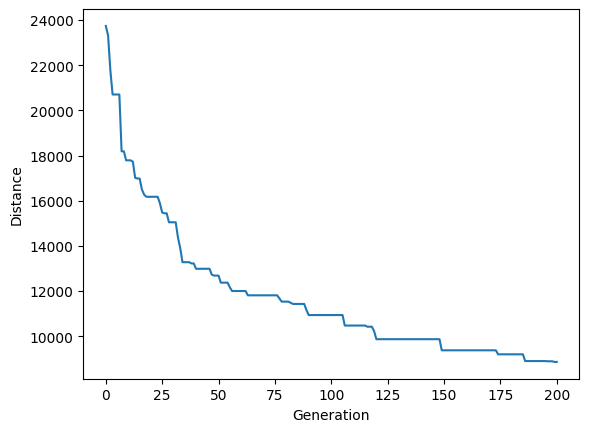

In [ ]:
genetic_algorithm_plot(population=cityList, population_size=100, elite_size=20, mutation_rate=0.01, generations=200, crossover_function=OX1_crossover, mutator_function=DM_mutate)

## Run with different operators

In [ ]:
def get_current_memory_info():
   current_process = psutil.Process()
   return current_process.memory_info().rss

crossover_functions = {
    OX1_crossover: "OX1",
    OX2_crossover: "OX2",
    POS_crossover: "POS",
    ER_crossover: "ER",
    PMX_crossover: "PMX",
    CX_crossover: "CX",
    AP_crossover: "AP"
}
mutation_functions = {
    DM_mutate: "DM",
    ISM_mutate: "ISM",
    IVM_mutate: "IVM",
    EM_mutate: "EM",
    SIM_mutate: "SIM",
    SM_mutate: "SM"
}
results = {}
for mutation_function, mutation_function_name in mutation_functions.items():
    for crossover_function, crossover_function_name in crossover_functions.items():
        print(f'calculating {mutation_function_name} {crossover_function_name}...')
        tracemalloc.start()
        start_time = datetime.datetime.now()
        algorithm_output = genetic_algorithm(population=cityList, population_size=100, elite_size=20, mutation_rate=0.07, generations=200, crossover_function=crossover_function, mutator_function=mutation_function)
        current, peak = tracemalloc.get_traced_memory()
        end_time = datetime.datetime.now()
        tracemalloc.stop()
        results[f'{mutation_function_name}-{crossover_function_name}'] = (algorithm_output, (end_time-start_time), peak)
        print(results[f'{mutation_function_name}-{crossover_function_name}'])

calculating DM OX1...
(9873.001541617368, datetime.timedelta(seconds=60, microseconds=298240), 300752)
calculating DM OX2...
(20193.499584606478, datetime.timedelta(seconds=59, microseconds=319668), 159668)
calculating DM POS...
(12027.327670206345, datetime.timedelta(seconds=59, microseconds=409481), 224729)
calculating DM ER...
(9562.171887976932, datetime.timedelta(seconds=62, microseconds=798728), 315908)
calculating DM PMX...
(10526.993351598361, datetime.timedelta(seconds=59, microseconds=204807), 235317)
calculating DM CX...
(10586.16529579478, datetime.timedelta(seconds=60, microseconds=258834), 235585)
calculating DM AP...
(11525.498820583116, datetime.timedelta(seconds=58, microseconds=305733), 216437)
calculating ISM OX1...
(9474.329293670677, datetime.timedelta(seconds=56, microseconds=461665), 210484)
calculating ISM OX2...
(21990.500877775987, datetime.timedelta(seconds=58, microseconds=921787), 322479)
calculating ISM POS...
(9953.146078887326, datetime.timedelta(seconds

In [ ]:
# import json
# print(json.dumps(results,indent=1))
print(results)

{'DM-OX1': (9873.001541617368, datetime.timedelta(seconds=60, microseconds=298240), 300752), 'DM-OX2': (20193.499584606478, datetime.timedelta(seconds=59, microseconds=319668), 159668), 'DM-POS': (12027.327670206345, datetime.timedelta(seconds=59, microseconds=409481), 224729), 'DM-ER': (9562.171887976932, datetime.timedelta(seconds=62, microseconds=798728), 315908), 'DM-PMX': (10526.993351598361, datetime.timedelta(seconds=59, microseconds=204807), 235317), 'DM-CX': (10586.16529579478, datetime.timedelta(seconds=60, microseconds=258834), 235585), 'DM-AP': (11525.498820583116, datetime.timedelta(seconds=58, microseconds=305733), 216437), 'ISM-OX1': (9474.329293670677, datetime.timedelta(seconds=56, microseconds=461665), 210484), 'ISM-OX2': (21990.500877775987, datetime.timedelta(seconds=58, microseconds=921787), 322479), 'ISM-POS': (9953.146078887326, datetime.timedelta(seconds=59, microseconds=316116), 207294), 'ISM-ER': (9485.098450725945, datetime.timedelta(seconds=60, microseconds=